In this example a simple SFINCS compound flood model will be made, using the underlying Python functions of HydroMT-SFINCS to build a model.

The model is situated in Northern Italy, where a small selection of topography and bathymetry data has already been made available for you to try the examples.

In [1]:
import os
import sys
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import geopandas as gpd

from hydromt_sfincs import SfincsModel
from hydromt_sfincs import utils

C:\Users\leijnse\AppData\Local\Temp\ipykernel_143932\1200288298.py:6: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


This example shows how to build a simple SFINCS model on a regular grid, containing an elevation dep-file, offshore water level forcing and an upstream discharge input forcing.
For making a more advanced model including e.g. spatially varying infiltration and roughness, see the example notebook: build_advanced_subgrid_compound_model_from_script.ipynb

In case you want to adjust this example to build a SFINCS model anywhere else in the world, you will have to add your own datasets to HydroMT's data catalog. For more info on that, see the example notebook: example_datasources.ipynb

Steps followed in this notebook to build your SFINCS model:
<ul> 
<li> 1. Open SfincsModel class, set data library and output folder </li>
<li> 2. Specify characteristics of the wanted grid </li>
<li> 3. Load in wanted elevation datasets </li>
<li> 4. Make mask of active and inactive cells </li>
<li> 5. Update mask with water level boundary cells</li>
<li> 6. Add water level time-series as forcing</li>
<li> 7. Add an upstream discharge time-series as forcing</li>
<li> 8. Show model</li>
<li> 9. Save all files</li>
</ul> 

Let's get started!

1. Open SfincsModel class, set data library and output folder:

In [2]:
# Initialize SfincsModel Python class with the artifact data catalog which contains publically available data for North Italy
sf = SfincsModel(data_libs=["artifact_data"], root="sfincs_compound_test")

2. Specify characteristics of the wanted grid and generate grid:

For more info about how to define a grid see: https://sfincs.readthedocs.io/en/latest/input.html#grid-characteristics

In [3]:
# Specify an input dictionary with the grid settings x0,y0,dx,dy,nmax,mmax,rotation and epsg code.
inp_dict = {
    "x0": 310000,   
    "y0": 5040000,
    "dx": 100.0,
    "dy": 100.0,
    "nmax": 250,
    "mmax": 250,
    "rotation": 0,
    "epsg": 32633,
}

# create SFINCS model with regular grid and characteristics of the input dictionary:
sf.create_grid(grid_type="regular", **inp_dict)

# the input file is automatically updated, and displayed below:
sf.config

{'mmax': 250,
 'nmax': 250,
 'dx': 100.0,
 'dy': 100.0,
 'x0': 310000,
 'y0': 5040000,
 'rotation': 0,
 'latitude': 0.0,
 'tref': datetime.datetime(2010, 2, 1, 0, 0),
 'tstart': datetime.datetime(2010, 2, 1, 0, 0),
 'tstop': datetime.datetime(2010, 2, 2, 0, 0),
 'tspinup': 60.0,
 'dtmapout': 600.0,
 'dthisout': 600.0,
 'dtrstout': 0.0,
 'dtmaxout': 0.0,
 'trstout': -999.0,
 'dtwnd': 1800.0,
 'alpha': 0.75,
 'theta': 0.9,
 'huthresh': 0.01,
 'manning': 0.04,
 'manning_land': 0.04,
 'manning_sea': 0.02,
 'rgh_lev_land': 0.0,
 'zsini': 0.0,
 'qinf': 0.0,
 'igperiod': 120.0,
 'rhoa': 1.25,
 'rhow': 1024.0,
 'dtmax': 999.0,
 'maxlev': 999.0,
 'bndtype': 1,
 'advection': 0,
 'baro': 0,
 'pavbnd': 0,
 'gapres': 101200.0,
 'advlim': 9999.9,
 'stopdepth': 1000.0,
 'crsgeo': 0,
 'inputformat': 'bin',
 'outputformat': 'net',
 'cdnrb': 3,
 'cdwnd': [0.0, 28.0, 50.0],
 'cdval': [0.001, 0.0025, 0.0015],
 'epsg': 32633}

3. Load in wanted elevation datasets:

In [4]:
# We would like to use the size of the generated grid, to only load in the data covering that grid, to reduce time
region = sf.reggrid.empty_mask.raster.box
sf.set_geoms(region, "region")

In [5]:
# In this example we want to combine 2 elevation datasets, merit_hydro as elevation and gebco as bathymetry, in that order. 

# Here these 2 are loaded from the datacatalog and added to one list of elevation datasets (you could add more yourself if wanted, in case made available in your data catalog)
da_dep1 = sf.data_catalog.get_rasterdataset("merit_hydro", variables=["elevtn"], geom=sf.region, buffer=5)

da_dep2 = sf.data_catalog.get_rasterdataset("gebco", variables=["elevtn"], geom=sf.region, buffer=5)

# Provide merge arguments together with xr.DataAraay
da_dep_lst = [{"da":da_dep1}, {"da":da_dep2, "zmax":0, "offset":0}]

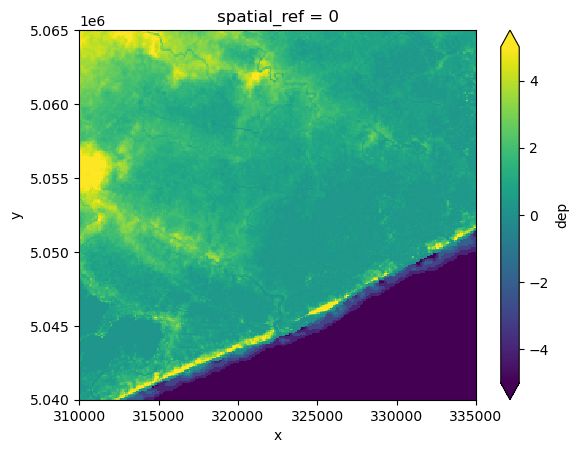

In [6]:
# Add depth information to modelgrid based on these chosen datasets
dep = sf.create_dep(da_dep_lst=da_dep_lst)

# Make a plot of the merged topobathy, here colour limits are set between an elevation of -5 to 5 meters
sf.grid.dep.plot(x='x', y='y',vmin=-5, vmax=5)

4. Make mask of active and inactive cells:

For more info about what the msk-file is see: https://sfincs.readthedocs.io/en/latest/input.html#mask-file

3 gaps outside valid elevation range < 10 km2.


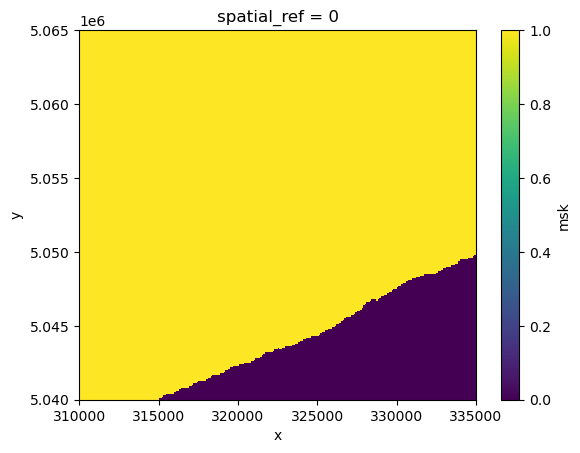

In [9]:
# Here we generate the mask of active (msk=1) and inactive cells (msk=0), determining what cells on your grid should be used.

# Choosing how to choose you active cells can be based on multiple criteria, here we only specify a minimum elevation of -5 meters
sf.create_mask_active( elv_min=-5, reset_mask=True)

# Make a plot of the mask file
sf.mask.plot(x='x', y='y')

# NOTE:
# - The given output of HydroMT says "3 gaps outside valid elevation range < 10 km2"
#   HydroMT does some smart filtering that if small groups of inactive cells are found, surrounded by active cells, these are still included as active, in this case 3 gaps.
#   You can control the size of these gaps to filter by adding ",fill_area = 10 km2)" in create_mask_active()
# - reset_bounds=True means that every time you start clean with defining your msk cells, if on False (default) you build on the prevous time you ran that function

5. Update mask with water level boundary cells:

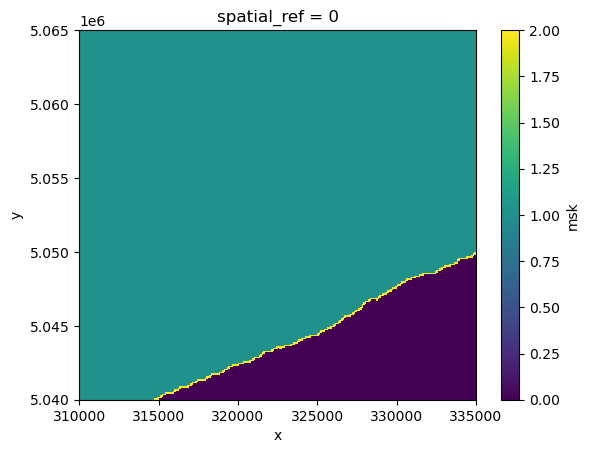

In [10]:
# In SFINCS you can specify cells where you want to force offshore water levels (msk=2), or outflow boundaries (msk=3)
# For more info about what the msk-file is see: https://sfincs.readthedocs.io/en/latest/input.html#mask-file

# Here we add water level cells along the coastal boundary, for cells up to an elevation of -5 meters
sf.create_mask_bounds(btype="waterlevel", elv_max=-5, reset_bounds=True)

# Make a plot of the mask file
sf.mask.plot(x='x', y='y')

# NOTE:
# - As you can see now, also msk=2 values have been added along the coastal boundary
# - reset_bounds=True means that every time you start clean with defining your msk=2 cells, if on False (default) you build on the prevous time you ran that function

By now we have made all basic SFINCS spatial layers to make the mskfile and depfile, now we're going to add some forcing...

6. Add water level time-series as forcing:

In [11]:
# Change period of model simulation time, specified in yyyymmdd HHMMSS --> simulation time here is 12 hours
sf.set_config("tref", "20100201 000000")
sf.set_config("tstart", "20100201 000000")
sf.set_config("tstop", "20100201 120000")

sf.config

{'mmax': 250,
 'nmax': 250,
 'dx': 100.0,
 'dy': 100.0,
 'x0': 310000,
 'y0': 5040000,
 'rotation': 0,
 'latitude': 0.0,
 'tref': '20100201 000000',
 'tstart': '20100201 000000',
 'tstop': '20100201 120000',
 'tspinup': 60.0,
 'dtmapout': 600.0,
 'dthisout': 600.0,
 'dtrstout': 0.0,
 'dtmaxout': 0.0,
 'trstout': -999.0,
 'dtwnd': 1800.0,
 'alpha': 0.75,
 'theta': 0.9,
 'huthresh': 0.01,
 'manning': 0.04,
 'manning_land': 0.04,
 'manning_sea': 0.02,
 'rgh_lev_land': 0.0,
 'zsini': 0.0,
 'qinf': 0.0,
 'igperiod': 120.0,
 'rhoa': 1.25,
 'rhow': 1024.0,
 'dtmax': 999.0,
 'maxlev': 999.0,
 'bndtype': 1,
 'advection': 0,
 'baro': 0,
 'pavbnd': 0,
 'gapres': 101200.0,
 'advlim': 9999.9,
 'stopdepth': 1000.0,
 'crsgeo': 0,
 'inputformat': 'bin',
 'outputformat': 'net',
 'cdnrb': 3,
 'cdwnd': [0.0, 28.0, 50.0],
 'cdval': [0.001, 0.0025, 0.0015],
 'epsg': 32633,
 'depfile': 'sfincs.dep',
 'mskfile': 'sfincs.msk',
 'indexfile': 'sfincs.ind'}

a. specify water level input locations:

For more info about what the bndfile is see: https://sfincs.readthedocs.io/en/latest/input_forcing.html#water-level-points

In [12]:
# Here we specify at what x&y-locations we have measured/modelled input water level data in the bndfile of SFINCS:

# x&y-locations in same coordinate reference system as the grid:
x = [320000, 334000]
y = [5041000, 5045000]

# add to Geopandas dataframe as needed by HydroMT
pnts = gpd.points_from_xy(x, y)
index = [1, 2]  # NOTE that the index should start at one
bnd = gpd.GeoDataFrame(index=index, geometry=pnts, crs=sf.crs)

# show what has been created:
bnd

,geometry
1,POINT (320000.000 5041000.000)
2,POINT (334000.000 5045000.000)


b. Make up some time-series:

For more info about what the bzsfile is see: https://sfincs.readthedocs.io/en/latest/input_forcing.html#water-level-time-serie

In [13]:
# Here we specify at what times we are providing water level input, and afterwards what the values are per input location:

# In this case we will provide 3 values (periods=3) between the start (tstart=20100201 000000) and the end (tstop=20100201 120000) of the simulation:
time = pd.date_range(start=utils.parse_datetime(sf.config["tstart"]), end=utils.parse_datetime(sf.config["tstop"]), periods=3)

# and the actual water levels, in this case for input location 1 a water level rising from 0 to 2 meters and back to 0:
bzs = [[0, 0.25], 
       [2.0, 2.25], 
       [0, 0.25]]

bzspd = pd.DataFrame(index=time, columns=index, data=bzs)
bzspd

,1,2
2010-02-01 00:00:00,0.0,0.25
2010-02-01 06:00:00,2.0,2.25
2010-02-01 12:00:00,0.0,0.25


(<Figure size 600x300 with 1 Axes>,
 [<AxesSubplot:title={'center':'SFINCS waterlevel forcing (bzs)'}, ylabel='waterlevel\n[m+ref]'>])

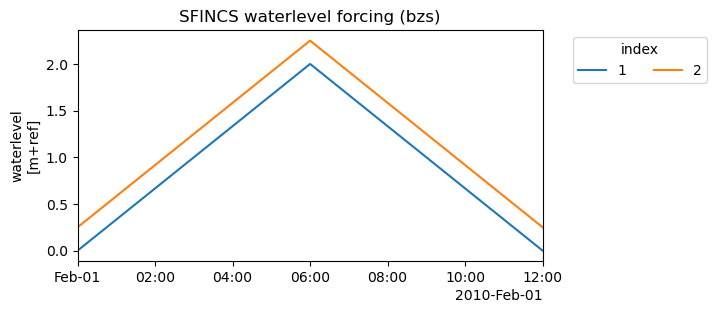

In [14]:
# Actually add it to the SFINCS model class:
sf.create_waterlevel_forcing(df_ts = bzspd, gdf_locs=bnd)

# Plot time-series:
sf.plot_forcing()

7. Add an upstream discharge time-series as forcing

a. specify discharge input locations: srcfile

For more info about what the srcfile is see: https://sfincs.readthedocs.io/en/latest/input_forcing.html#discharge-points

b. specify discharge time-series: disfile

For more info about what the disfile is see: https://sfincs.readthedocs.io/en/latest/input_forcing.html#discharge-time-series

(<Figure size 600x600 with 2 Axes>,
 array([<AxesSubplot:title={'center':'SFINCS waterlevel forcing (bzs)'}, ylabel='waterlevel\n[m+ref]'>,
        <AxesSubplot:title={'center':'SFINCS discharge forcing (dis)'}, ylabel='discharge\n[m3.s-1]'>],
       dtype=object))

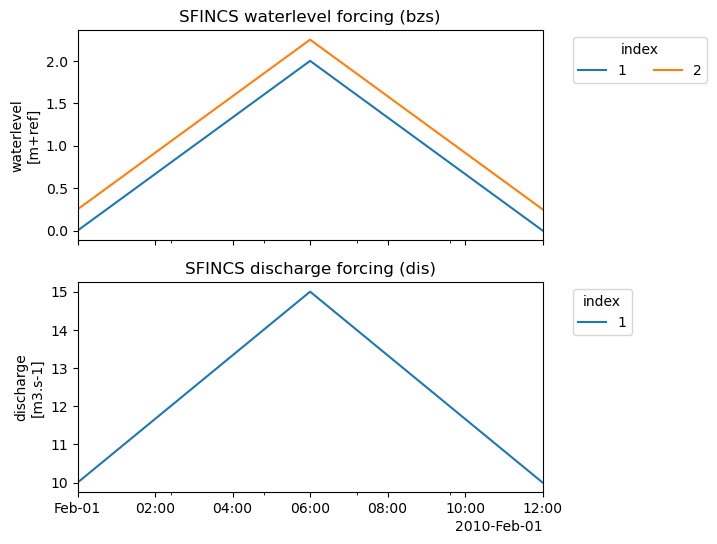

In [15]:
# We follow exactly the same steps as for the water level forcing, but now specify 1 location where we specify discharges in m3/s
x = [311696]
y = [5053709]

# add to Geopandas dataframe as needed by HydroMT
pnts = gpd.points_from_xy(x, y)
index = [1]  # NOTE that the index should start at one
src = gpd.GeoDataFrame(index=index, geometry=pnts, crs=sf.crs)

time = pd.date_range(start=utils.parse_datetime(sf.config["tstart"]), end=utils.parse_datetime(sf.config["tstop"]), periods=3)

# and the actual water levels, in this case for input location 1 a water level rising from 0 to 2 meters and back to 0:
dis = [[10.0], 
       [15.0], 
       [10.0]]

dispd = pd.DataFrame(index=time, columns=index, data=dis)

# NOTE: only now we call the function create_discharge_forcing
sf.create_discharge_forcing(df_ts = dispd, gdf_locs=src)

# Plot time-series:
sf.plot_forcing()


In case you want to add other types of forcing, see the example notebook example_forcing.ipynb for other types.

Or have a look at: https://sfincs.readthedocs.io/en/latest/input_forcing.html

8. Show model

(<Figure size 1000x833.333 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'SFINCS dep map'}, xlabel='x coordinate UTM zone 33N [m]', ylabel='y coordinate UTM zone 33N [m]'>)

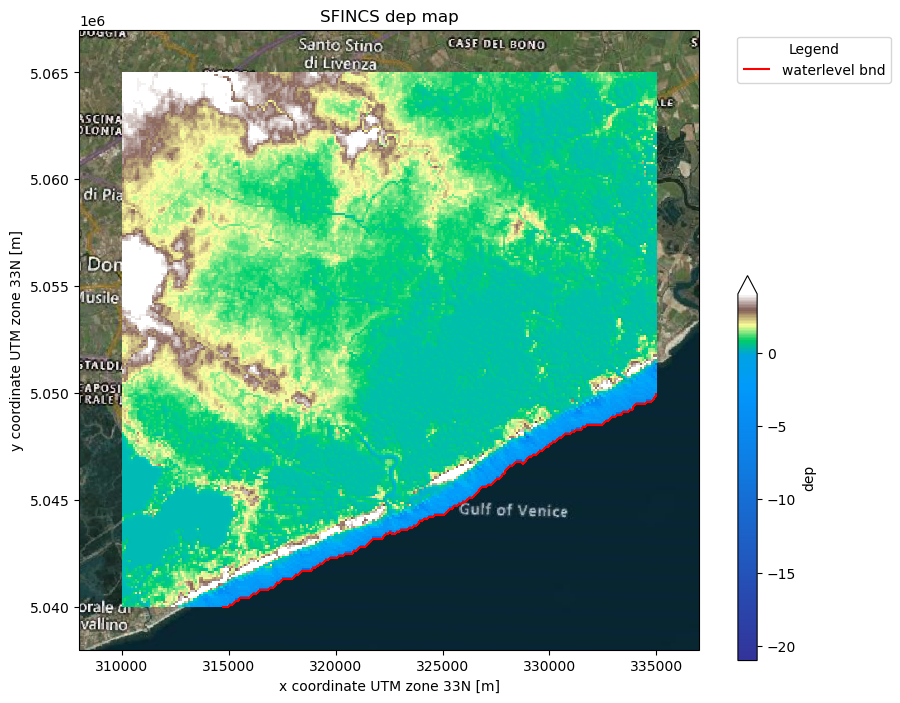

In [16]:
# Use predefined plotting function 'plot_basemap' to show your full SFINCS model setup
sf.plot_basemap()

9. Save all files

In [17]:
sf.write() # write all

In [20]:
# Show created files in folder:
dir_list = os.listdir(sf.root)
print(dir_list)

['figs', 'gis', 'hydromt.log', 'hydromt_data.yml', 'sfincs.bnd', 'sfincs.bzs', 'sfincs.dep', 'sfincs.dis', 'sfincs.ind', 'sfincs.inp', 'sfincs.msk', 'sfincs.src']


Your basemap and forcing figures are saved in the folder 'figs' and GIS files (tiff & geojson) of your model setup in 'gis'.

Now you have made a model, you can progress to the notebook: run_sfincs_model.ipynb